# Imports

In [21]:
# PyABC imports
from pyabc import (ABCSMC, Distribution, RV,
                   History, MedianEpsilon)
from pyabc.populationstrategy import ConstantPopulationSize, AdaptivePopulationSize
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler

In [22]:
# Custom imports
from ionchannelABC import (ion_channel_sum_stats_calculator,
                           IonChannelAcceptor,
                           IonChannelDistance,
                           EfficientMultivariateNormalTransition,
                           plot_parameter_sensitivity)

In [23]:
# Other necessary imports
import numpy as np
import subprocess
import pandas as pd
import io
import os
import tempfile

In [24]:
# Plotting imports
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config Inline.Backend.figure_format = 'retina'

# Create the ion channel model

In [25]:
from channels.iha import iha as model
#model.sample({})

# Get experimental measurements

In [26]:
measurements = model.get_experiment_data()
obs = measurements.to_dict()['y']
exp = measurements.to_dict()['exp']
errs = measurements.to_dict()['errs']

# Set limits and generate uniform initial priors

In [7]:
limits = dict(g_ha=(0, 0.2),
              p1=(0, 100),
              p2=(0, 10),
              p3=(0, 1),
              p4=(-100, 100),
              p5=(0, 100),
              p6=(0, 1),
              p7=(0, 200),
              p8=(-100, 0),
              k_i_haNa=(0, 1))
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

# Test parameter sensitivity

In [8]:
parameters = ['iha.'+k for k in limits.keys()]

In [9]:
distance_fn=IonChannelDistance(
    obs=obs,
    exp_map=exp,
    err_bars=errs,
    err_th=0.1)

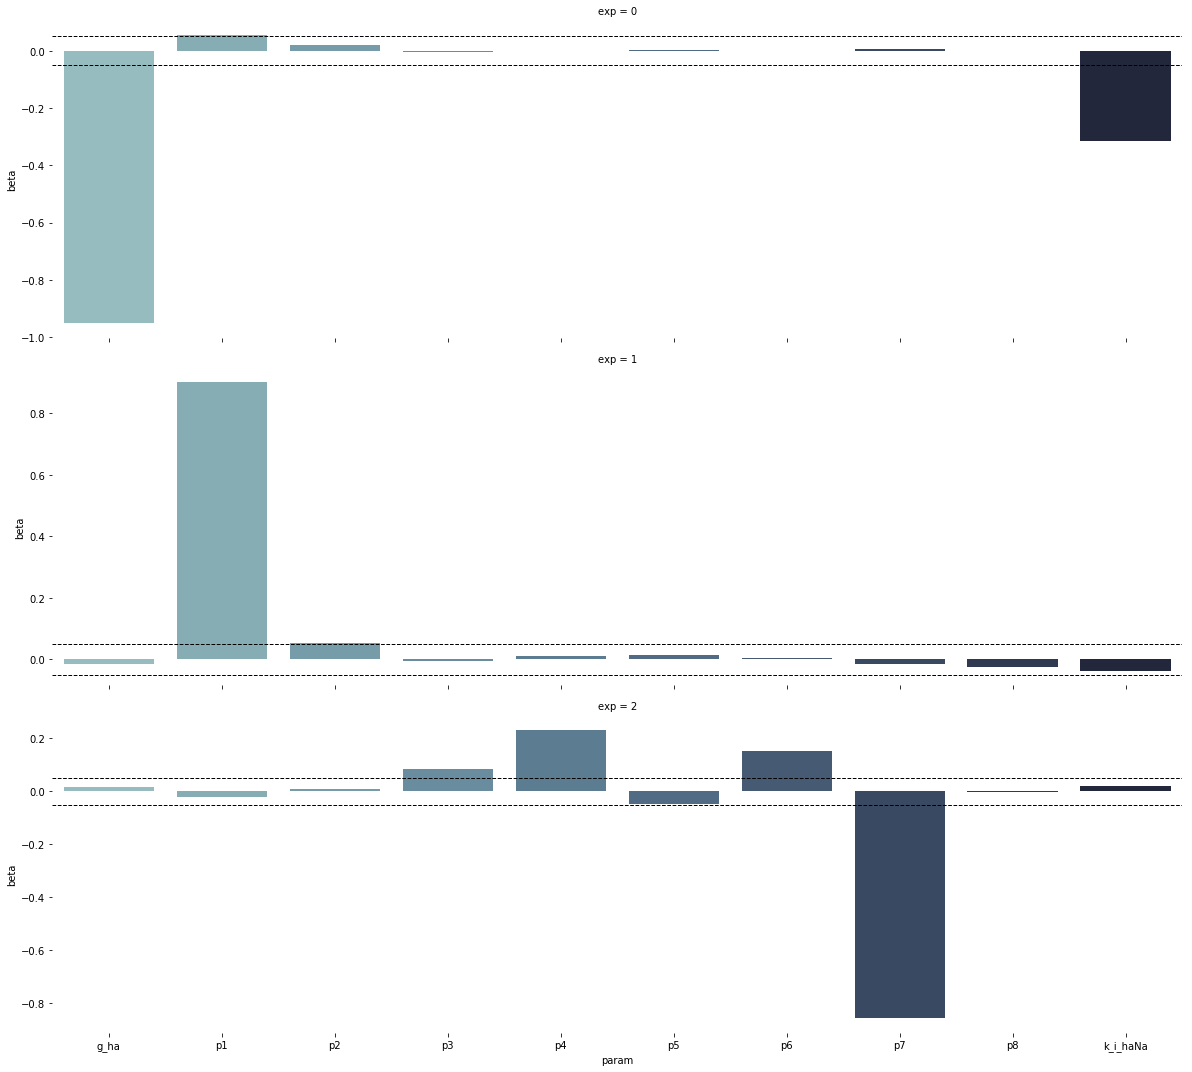

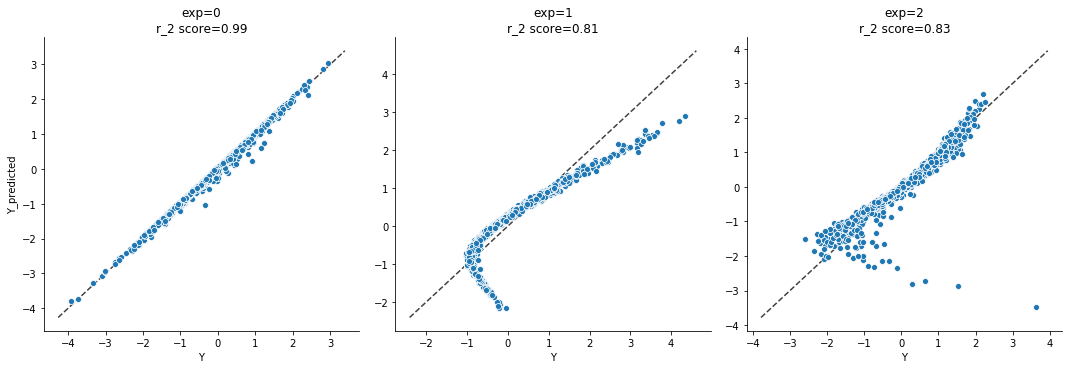

In [10]:
grid1, grid2 = plot_parameter_sensitivity(
    model,
    parameters,
    distance_fn,
    sigma=0.1,
    n_samples=1000,
    plot_cutoff=0.05)

In [11]:
grid1.savefig('results/iha/sensitivity.pdf')
grid2.savefig('results/iha/sensitivity_fit.pdf')

In [27]:
limits = dict(g_ha=(0, 0.2),
              p1=(0, 100),
              p3=(0, 1),
              p4=(-200, 100),
              p5=(0, 100),
              p6=(0, 1),
              p7=(0, 200),
              k_i_haNa=(0, 1))
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

# Initialise database

In [8]:
db_path = ('sqlite:///' + 
           os.path.join(tempfile.gettempdir(), "hl-1_iha.db"))
print(db_path)

sqlite:////scratch/cph211/tmp/hl-1_iha.db


In [32]:
# Let's log all the sh!t
import logging
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [33]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 obs=obs,
                 exp_map=exp,
                 err_bars=errs,
                 err_th=0.1),
             #population_size=ConstantPopulationSize(
             #    nr_particles=10000),
             population_size=AdaptivePopulationSize(
                 start_nr_particles=5000,
                 mean_cv=0.2,
                 max_population_size=5000,
                 min_population_size=2500),
             summary_statistics=ion_channel_sum_stats_calculator,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(),
             sampler=MulticoreEvalParallelSampler(n_procs=12),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {0: 0.23291016577034931, 1: 0.32545103225145916, 2: 0.4167902903278747, 3: 0.44824616129601674, 4: 0.5939261637172222, 5: 0.5939261637172222, 6: 0.6788076721341819, 7: 0.7233305530634934, 8: 0.7233305530634934, 9: 0.7233305530634934, 10: 0.7233305530634934, 11: 0.7233305530634934, 12: 0.7233305530634934, 13: 0.7233305530634934, 14: 0.7233305530634934, 15: 1.7185479328719149, 16: 1.7185479328719149, 17: 1.7185479328719149, 18: 1.7185479328719149, 19: 1.7185479328719149, 20: 1.7185479328719149, 21: 1.7185479328719149, 22: 1.7185479328719149, 23: 1.248162135043625, 24: 1.248162135043625, 25: 1.248162135043625, 26: 1.248162135043625, 27: 1.248162135043625, 28: 0.932608949870775, 29: 0.5934784226450392, 30: 0.40801641556846413}
DEBUG:Epsilon:init quantile_epsilon initial_epsilon=from_sample, quantile_multiplier=1


In [34]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=2, start_time=2018-09-09 16:06:02.037639, end_time=None)>
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.1-py3.6.egg/pyabc/epsilon.py:321: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  distances = weighted_distances.distance.as_matrix()
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.1-py3.6.egg/pyabc/epsilon.py:325: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  weights = weighted_distances.w.as_matrix()
INFO:Epsilon:initial epsilon is 16.270619426473765


In [ ]:
history = abc.run(minimum_epsilon=0.01, max_nr_populations=20, min_acceptance_rate=0.001)

INFO:ABC:t:0 eps:16.270619426473765
DEBUG:ABC:now submitting population 0
DEBUG:ABC:
total nr simulations up to t =0 is 10126
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.1-py3.6.egg/pyabc/epsilon.py:321: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  distances = weighted_distances.distance.as_matrix()
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.1-py3.6.egg/pyabc/epsilon.py:325: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  weights = weighted_distances.w.as_matrix()
DEBUG:Epsilon:new eps, t=1, eps=6.81305914425186
INFO:ABC:t:1 eps:6.81305914425186
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.1-py3.6.egg/pyabc/storage/history.py:200: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  w_arr = w.w.as_matrix()
/scratch/cph211/miniconda3/envs

# Results analysis

In [28]:
db_path = 'sqlite:///results/iha/hl-1_iha.db'
history = History(db_path)
history.all_runs()

[<ABCSMC(id=1, start_time=2018-09-09 08:24:06.028337, end_time=2018-09-09 15:17:27.816500)>,
 <ABCSMC(id=2, start_time=2018-09-09 16:06:02.037639, end_time=2018-09-09 23:08:34.474238)>]

In [29]:
history.id = 2

In [30]:
sns.set_context('talk')

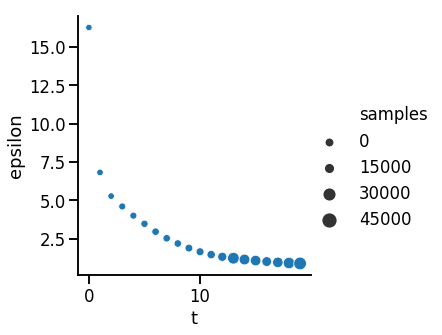

In [31]:
evolution = history.get_all_populations()
grid = sns.relplot(x='t', y='epsilon', size='samples', data=evolution[evolution.t>=0])
grid.savefig('results/iha/eps_evolution.pdf')

In [32]:
df, w = history.get_distribution(m=0)

/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.1-py3.6.egg/pyabc/storage/history.py:200: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  w_arr = w.w.as_matrix()


/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.1-py3.6.egg/pyabc/transition/multivariatenormal.py:64: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self._X_arr = X.as_matrix()


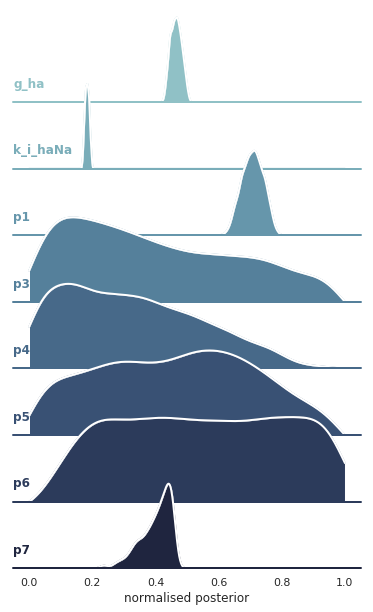

In [14]:
from ionchannelABC import plot_parameters_kde
g = plot_parameters_kde(df, w, limits, aspect=5, height=1.1)

In [15]:
g.savefig('results/iha/parameters_kde.pdf')

# Samples for quantitative analysis

In [33]:
# Generate parameter samples
n_samples = 100
df, w = history.get_distribution(m=0)
th_samples = df.sample(n=n_samples, weights=w, replace=True).to_dict(orient='records')

/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.1-py3.6.egg/pyabc/storage/history.py:200: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  w_arr = w.w.as_matrix()


In [34]:
# Generate sim results samples
samples = pd.DataFrame({})
for i, th in enumerate(th_samples):
    output = model.sample(pars=th, n_x=50)
    output['sample'] = i
    output['distribution'] = 'post'
    samples = samples.append(output, ignore_index=True)

/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


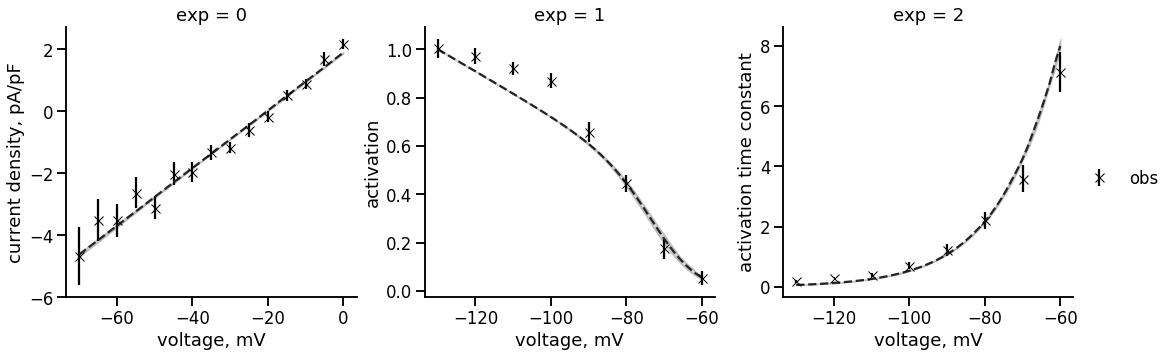

In [35]:
from ionchannelABC import plot_sim_results
g = plot_sim_results(samples, obs=measurements)

# Set axis labels
xlabels = ["voltage, mV", "voltage, mV", "voltage, mV"]
ylabels = ["current density, pA/pF", "activation", "activation time constant"]
for ax, xl in zip(g.axes.flatten(), xlabels):
    ax.set_xlabel(xl)
for ax, yl in zip(g.axes.flatten(), ylabels):
    ax.set_ylabel(yl)

In [36]:
g.savefig('results/iha/iha_sim_results.pdf')

In [37]:
# Fit linear line to current-voltage relationship
grouped = samples[samples['exp']==0].groupby('sample')
from scipy.optimize import curve_fit
def fit_linear_line(group):
    def linear_line(x, m, c):
        return m*x + c
    popt, _ = curve_fit(linear_line, group.x, group.y)
    m, c = popt[0], popt[1]
    x_intercept = -c / m
    return (x_intercept, m*1000)
output = grouped.apply(fit_linear_line).apply(pd.Series)

In [38]:
print(output.mean())
print(output.std())

0   -20.370234
1    93.077957
dtype: float64
0    0.650434
1    3.156427
dtype: float64


In [39]:
import scipy.stats as st
intercept = output[0].tolist()
rv = st.rv_discrete(values=(intercept, [1/len(intercept),]*len(intercept)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -20.286562132822553
95% CI: (-21.595680320788755, -19.26516773793096)


In [40]:
slope = output[1].tolist()
rv = st.rv_discrete(values=(slope, [1/len(slope),]*len(slope)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 93.10222319434108
95% CI: (87.3406956142571, 99.25241889516901)


In [41]:
# Fit of activation to Boltzmann equation
grouped = samples[samples['exp']==1].groupby('sample')
def fit_boltzmann(group):
    def boltzmann(V, Vhalf, K):
        return 1-1/(1+np.exp((Vhalf-V)/K))
    guess = (-100, 10)
    popt, _ = curve_fit(boltzmann, group.x, group.y,
                        bounds=([-200, 0], [0, 20]))
    return popt
output = grouped.apply(fit_boltzmann).apply(pd.Series)

In [42]:
print(output.mean())
print(output.std())

0   -85.848175
1    13.753345
dtype: float64
0    1.806274
1    1.225169
dtype: float64


In [43]:
Vhalf = output[0].tolist()
rv = st.rv_discrete(values=(Vhalf, [1/len(Vhalf),]*len(Vhalf)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -85.68939988456549
95% CI: (-88.94472238741307, -82.86470982539777)


In [44]:
slope = output[1].tolist()
rv = st.rv_discrete(values=(slope, [1/len(slope),]*len(slope)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 13.708939917852057
95% CI: (11.732205754390924, 15.86560257100461)


In [45]:
# Values of time constants at specific voltages
grouped = samples[samples['exp']==2].groupby('sample')
def get_tau(group):
    tau_60 = float(group[group.x==-60].y)
    tau_130 = float(group[group.x==-130].y)
    return (tau_60, tau_130)
output = grouped.apply(get_tau).apply(pd.Series)

In [46]:
print(output.mean())
print(output.std())

0    8.016504
1    0.065143
dtype: float64
0    0.743798
1    0.007042
dtype: float64


In [47]:
tau60 = output[0].tolist()
rv = st.rv_discrete(values=(tau60, [1/len(tau60),]*len(tau60)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 7.980608366742066
95% CI: (6.376243469260935, 9.211873774086307)


In [48]:
tau130 = output[1].tolist()
rv = st.rv_discrete(values=(tau130, [1/len(tau130),]*len(tau130)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 0.06493348310120706
95% CI: (0.0517044208894066, 0.08188310967716378)


# Weights of distance function

In [ ]:
from ionchannelABC import plot_distance_weights
grid = plot_distance_weights(model, distance_fn)

In [36]:
grid.savefig('results/iha/dist_weights.pdf')